In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from typhon import plots
import xarray as xr
from scipy import integrate
from scipy import optimize

import konrad

plots.styles.use('typhon')

In [2]:
cp_air = 1004.64 #J kg-1 K-1
g = 9.80665 #m s-2
print(konrad.constants.g)
Rd = 287.0570048852906 #J kg-1 K-1 air
print(konrad.constants.Rv)
Rv = 461.52280830495 #J kg-1 K-1 water vapor
Lv = 2501000 #J kg-1
eps = Rd/Rv #dimensionless
e_sat_ref = 610.94 #Pa, saturation water vapor pressure for Tref = 273.15 K
T_ref = 273.15 #K
seconds_day = 24*60*60 #seconds in a day

lapse_dry = -g/cp_air #K/m

9.80665
461.52280830495


In [3]:
#WATER

def manabe_rh(rhs, p):
#    rh = np.maximum(0,rhs*(p/p[0]-0.02)/(1-0.02))
    rh = rhs*(p/p[0]-0.02)/(1-0.02)
    return rh

def fixed_rh(rhs,p):
    rh = np.ones_like(p)*rhs
    return rh
    
def rh_to_mmr(rh,T,p):
    mixing_ratio = rh_to_vmr(rh,T,p)*eps
    
    return mixing_ratio

def rh_to_vmr_fixed_strato(rh,T,p):
    mixing_ratio = np.maximum(5e-6,konrad.physics.relative_humidity2vmr(rh,p,T))
    
    return mixing_ratio

def rh_to_vmr(rh,T,p,itop):
    mixing_ratio = np.ones_like(T)
    vmr_itop = konrad.physics.relative_humidity2vmr(rh[itop],p[itop],T[itop])
    mixing_ratio[:itop] = konrad.physics.relative_humidity2vmr(rh[:itop],p[:itop],T[:itop])
    mixing_ratio[itop:] = vmr_itop
    
    return mixing_ratio

def vmr_to_rh(vmr,T,p):
    relative_humidity = konrad.physics.vmr2relative_humidity(vmr,p,T)
    
    return relative_humidity

def vmr_to_mmr(vmr):
    mass_mix = vmr*eps
    
    return mass_mix

def energy_to_water(energy):#kg m-2
    #if energy is in J s-1 m-2, comes back as kg s-1 m-2, ie, mm s-1 of precipitation
    # mass_atm = (p[0]-p[-1])/g
    mass_w = energy/Lv #* mass_atm
    return mass_w

def column_water_mass(vmr,ph): #kg m-2
    mmr = vmr_to_mmr(vmr) #kg kg-1
    dp = np.diff(ph)
    M_water = np.sum(-dp*mmr/g)
    
    return M_water
    
def opt_column_water_to_rh(M_water,T_atm,p,ph,itop):
    
    def fun(rhs):
        rh = manabe_rh(rhs, p)
        vmr = rh_to_vmr(rh,T_atm,p,itop)
        rh_w_mass = column_water_mass(vmr,ph)
        res = rh_w_mass - M_water
        return res
    
    rhs_opt = optimize.brentq(fun, 0., 2)
    rh_opt = manabe_rh(rhs_opt, p)
    return rh_opt

In [4]:
#AIR

def convective_top(T_con,T_rad):
    itop = np.where(T_radiation - atmosphere['T'][0] == 0)[0][0]
    
    return itop

def coldpoint(T):
    itop = np.where(np.diff(atmosphere['T'][0])>=0)[0][0]
    
    return itop

def height(p,T): #m
    rho = p/(Rd*T)
    z = integrate.cumulative_trapezoid(-1/(g*rho),p,initial = 0)
    return z

def MALR(T,p): #dlnT/dlnp
    r_sat = mmr_sat(T,p)
    A = (Lv*r_sat)/(Rd*T)
    B = (Lv**2*r_sat)/(cp_air*Rd*T**2)
    moist_lapse = - g/cp_air * (1+A)/(1+B)
    return moist_lapse

def T_MA(T_bl,p): #K
    T_atm = np.zeros((len(p)))
    T_atm[0] = T_bl
    for i in range(len(p)-1):
        lapse_z = MALR(T_atm[i],p[i])
        lapse_p = lapse_pressure(lapse_z)
        T_atm[i+1]=T_atm[i]*(p[i+1]/p[i])**(lapse_p)
    return T_atm

def lapse_pressure(lapse_z): #dlnT/dlnp, dT/dz
    l_p = -Rd/g * lapse_z
    return l_p


def T_atm_z(T_bl,z,lapse_z):
    Temp = T_bl + z*lapse_z
    return Temp

def T_atm_p(T_bl,p,lapse_p):
    Temp = T_bl * (p/p_s)**(lapse_p)
    return Temp

def moist_adiabat(p,T_bl,T_rad):
    T_moist_ad = konrad.lapserate.get_moist_adiabat(p,T_bl,T_min=0.)
    T_con = np.maximum(T_moist_ad,T_rad)
    
    return T_con

In [5]:
#FIRE

def TE(T,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g,p) #J m-2
    return energy #J m-2

def DSE(T,z,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g-z,p) #J m-2
    return energy #J m-2

def PE(z):
    energy = integrate.trapz(-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass

def T_bl_TE(thermal_energy, p, T_rad): #find T_bl conserving thermal energy
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl


def T_convection_TE(p, T_rad, SH): #find T after convective adjustment conserving thermal energy
    #note that here SH is the sensible heat for the whole timestep (J m-2) and not the flux itself (J m-2 s-1)
    thermal_energy = TE(T_rad,p) + SH
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm,p)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    T_con = moist_adiabat(p,T_bl,T_rad)
    return T_con


def T_convection_DSE(p, T_rad): #find T after convective adjustment conserving dry static energy
    #note that here SH is the sensible heat for the whole timestep (J m-2) and not the flux itself (J m-2 s-1)
    z_rad = height(p,T_rad)
    dry_static_energy = DSE(T_rad,z_rad,p) + SH
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        z_atm = height(p,T_atm)
        DSE_moist = DSE(T_atm,z_atm,p)
        res = DSE_moist-dry_static_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl

In [6]:
#EARTH

wind = 10 # wind speed m s-1
Cd = 0.001 # Drag coefficient unitless

def sensible_heat(T_bl,T_s,p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    sh = wind*Cd*rho_s*cp_air*(T_s-T_bl) #J s-1 m-2
    
    return sh

def latent_heat(vmr, T_bl, p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    
    rh = konrad.physics.vmr2relative_humidity(vmr,p_s,T_bl)
    mmr = vmr_to_mmr(vmr)
    mmr_sat = mmr/rh
    
    lh = wind*Cd*rho_s*Lv*(mmr_sat-mmr) #J s-1 m-2
    return lh

    
def SH_to_ws(T_bl,T_s,p_s,sh):
    rho_s = p_s/(Rd*T_bl) #kg m-3
    windspeed = sh/(Cd*rho_s*cp_air*(T_s-T_bl))
    
    return windspeed

In [7]:
%%time
#### PRECIPITATION TEST
heat_sink = 60.

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG(solar_constant=551.58)
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

conv_top = coldpoint(atmosphere['T'][0])

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])
atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev'])
print(M_w)

ndays = 3000
timestep = 0.5 #days
nsteps = int(ndays/timestep)

Bowen = 0.1
prec_eff = 1/(1+Bowen)
print(prec_eff)

printcounter = 0
status = 0

Ts_rec = []
Tbl_rec = []
rads_rec = []
rada_rec = []
LH_rec = []
SH_rec = []
PH_rec = []

for i in range(nsteps):
    #update heating rates
    
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)
    
    rad_heat_atm = np.ones_like(radiation['net_htngrt'][0])
    
    rad_heat_atm[:] = - np.diff(radiation['lw_flxu'][0] + radiation['sw_flxu'][0]-
                             (radiation['lw_flxd'][0] + radiation['sw_flxd'][0]))
    
    troposphere_radiation = np.sum(rad_heat_atm[:conv_top])
    atm_rad = np.sum(rad_heat_atm[:])
   
    heating_rates = np.ones_like(rad_heat_atm)
    heating_rates = (rad_heat_atm/cp_air * 
                                g/-np.diff(atmosphere['phlev']) * seconds_day)

    
    #update net radiaiton at surface

    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
    
    #temperature of atmosphere after radiative update
    atmosphere['T'] += heating_rates * timestep
    T_radiation = atmosphere['T'][0].copy()
    
    
    n_bl = 1
    vmr_bl = np.sum(atmosphere['H2O'][0,:n_bl])/n_bl
    old_T_bl = np.sum(T_radiation[:n_bl])/n_bl
    

    
#    print('pre rad',surface['temperature'])
        #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
#    print('post rad',surface['temperature'])
    LH = latent_heat(vmr_bl, surface['temperature'].copy(),atmosphere['phlev'][0])
    
    
    SH = sensible_heat(old_T_bl,surface['temperature'].copy(),atmosphere['phlev'][0])
#    print(SH,LH)
    
    prec_eff = np.minimum(1.,LH/(LH+SH))
#    print(prec_eff)
    prec_heating = prec_eff * troposphere_radiation #amount of energy invested in precipitation
    prec_mass = prec_heating/Lv
#    atmosphere['T'][0][:conv_top] -= (prec_eff)*heating_rates[:conv_top] * timestep
#    T_radiation = atmosphere['T'][0].copy()
    
    if (printcounter == 50):
        status += 1*printcounter
        Ts_rec.append(surface['temperature'].copy())
        Tbl_rec.append(old_T_bl)
        rads_rec.append(net_rad_surface)
        LH_rec.append(LH)
        SH_rec.append(SH)
        PH_rec.append(-prec_heating)
        rada_rec.append(-troposphere_radiation)
        
        printcounter = 0
    printcounter += 1
    
    
    
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    surface['temperature'] += ((- LH - SH) 
                               * seconds_day * timestep / surface.heat_capacity)
    
    atmosphere['T'][0] = T_convection_TE(atmosphere['plev'], T_radiation, 
                                         (SH - prec_heating) * seconds_day * timestep)

    
    #water adjustment
    conv_top = convective_top(atmosphere['T'][0],T_radiation)
    cold_point = coldpoint(atmosphere['T'][0])
    M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev']) + (prec_mass + LH/Lv)*seconds_day*timestep
    
    RH = opt_column_water_to_rh(M_w,atmosphere['T'][0],
                                atmosphere['plev'],atmosphere['phlev'],cold_point)
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],cold_point)

18.767710263973953
0.9090909090909091
CPU times: user 16min 39s, sys: 2.05 s, total: 16min 41s
Wall time: 16min 38s


In [8]:
print(SH,LH,prec_heating)

[-2.60878004] [110.04567796] [-110.04743523]


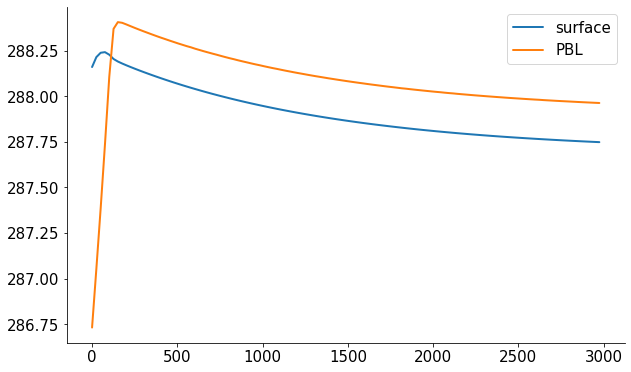

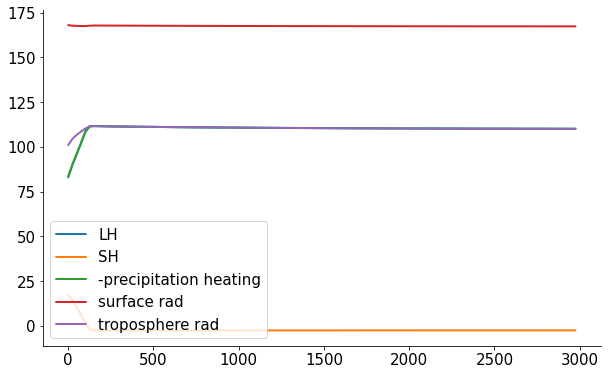

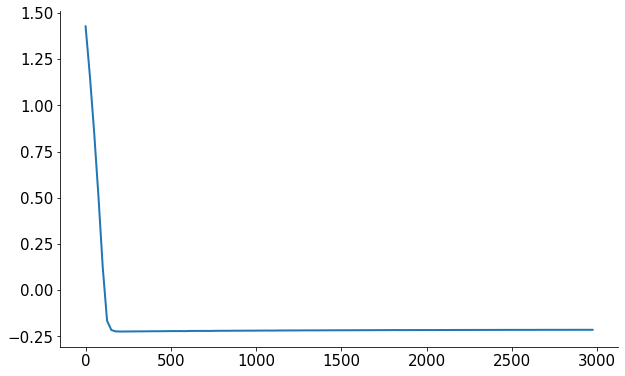

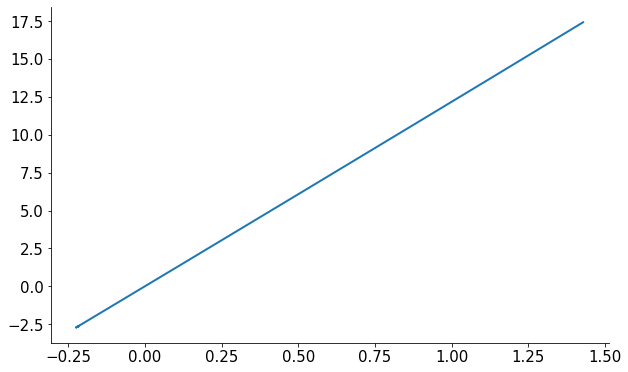

In [9]:
t = status/2
t = np.linspace(0,t,len(Ts_rec))
plt.plot(t,Ts_rec,label = 'surface')
plt.plot(t,Tbl_rec,label = 'PBL')
plt.legend()
plt.show()
plt.plot(t,LH_rec,label = 'LH')
plt.plot(t,SH_rec,label = 'SH')
plt.plot(t,PH_rec,label = '-precipitation heating')
plt.plot(t,rads_rec,label = 'surface rad')
plt.plot(t,rada_rec,label = 'troposphere rad')
plt.legend()
plt.show()
Tdif = []
for i in range(len(Ts_rec)):
    c = Ts_rec[i]-Tbl_rec[i]
    Tdif.append(c)
plt.plot(t,Tdif)
plt.show()
plt.plot(Tdif,SH_rec)
plt.show()

In [10]:
%%time
atmosphere_rce = konrad.atmosphere.Atmosphere(phlev)
surface_rce = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink = 66,
)

humidity_model = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
rce = konrad.RCE(
    atmosphere_rce,
    surface=surface_rce,  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration=int(ndays)/5, # Set maximum runtime.
    humidity = humidity_model
)
rce.run()


CPU times: user 41.4 s, sys: 30 ms, total: 41.5 s
Wall time: 41.4 s


[1.]
first with latent heat and precipitation, then without:
surface T 287.7258891731675 287.5019251351879
atmosphere PBL T 288.77365529119794 286.95473688296784
toa radiation [57.2853657] [63.94108461]
surface radiation 167.33354455596253 168.76245938052853
atmosphere radiative cooling [-110.04817886] -110.04817885722332 [-104.82137477]
sensible heat [-2.60878004]
precipitation heat (J s-1 m-2) and mass (mm day-1) [-110.04743523] [-3.80171867]
latent heat evaporation (J s-1 m-2) and mass (mm day-1) [110.04567796] [3.80165797]
Column mass of water vapor (kg m-2) [17.29468733]


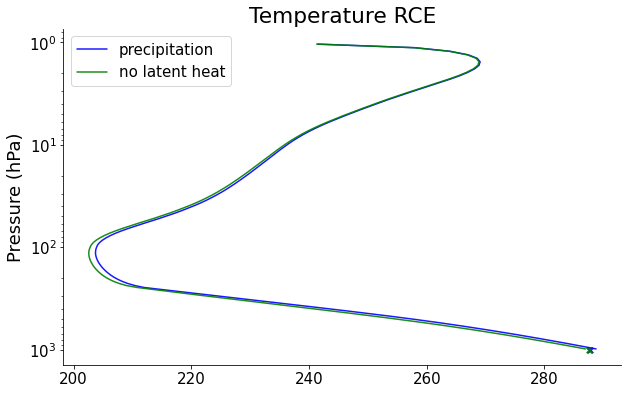

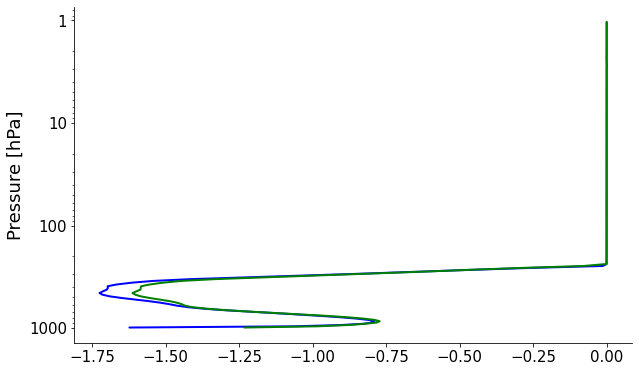

In [11]:
print(prec_eff)
print('first with latent heat and precipitation, then without:')
print('surface T',
      surface['temperature'][0],surface_rce['temperature'][0])
print('atmosphere PBL T',
      atmosphere['T'][0,0],atmosphere_rce['T'][0,0])
print('toa radiation',
      radiation['toa'],rce.radiation['toa'])
rad_surf_rce = (rce.radiation['lw_flxd'][0,0] + rce.radiation['sw_flxd'][0,0] - 
                    (rce.radiation['lw_flxu'][0,0] + rce.radiation['sw_flxu'][0,0]))
print('surface radiation',net_rad_surface, rad_surf_rce)
print('atmosphere radiative cooling',
      radiation['toa']-net_rad_surface, atm_rad, rce.radiation['toa']-rad_surf_rce)
print('sensible heat',SH)
print('precipitation heat (J s-1 m-2) and mass (mm day-1)',
      prec_heating, prec_mass * seconds_day)
print('latent heat evaporation (J s-1 m-2) and mass (mm day-1)', 
      LH, LH/Lv * seconds_day)
print('Column mass of water vapor (kg m-2)', M_w)


fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature RCE')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'blue', lw = 1.5, label = 'precipitation')
ax.plot(atmosphere_rce['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'green', lw = 1.5, label = 'no latent heat')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'blue', s = 30, marker ='x')
ax.scatter(surface_rce['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'green', s = 30, marker ='x')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        radiation['net_htngrt'][0], color = 'blue', label = 'precipitation')
plots.profile_p_log(atmosphere['plev'], 
                        rce.radiation['net_htngrt'][0], color = 'green', label = 'no latent heat')
plt.show()

In [12]:
print((net_rad_surface)
                               * seconds_day * timestep / surface.heat_capacity)
print((165)
                               * seconds_day * timestep / surface.heat_capacity)

0.033699661723278485
0.0332297041761482


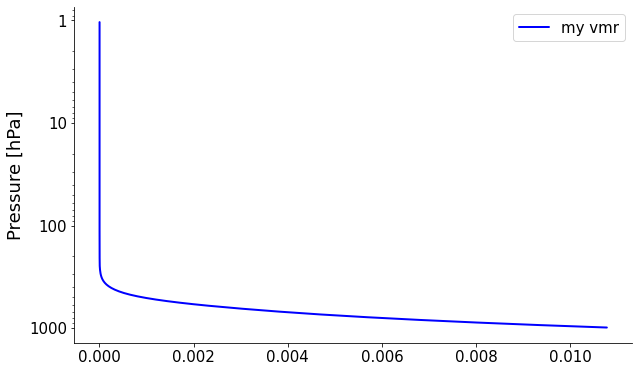

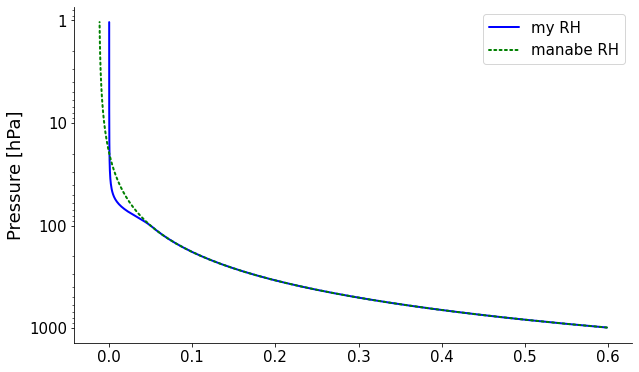

In [13]:
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['H2O'][0], color = 'blue', label = 'my vmr')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        vmr_to_rh(atmosphere['H2O'][0],atmosphere['T'][0],atmosphere['plev']),
                    color = 'blue', label = 'my RH')
plots.profile_p_log(atmosphere['plev'], RH, 
                    color = 'green', label = 'manabe RH', linestyle = 'dotted')
plt.legend()
plt.show()

In [14]:
print(atmosphere['phlev'][:4])

[100000.          97317.22068295  94666.49309856  92049.14849365]
